In [17]:
import numpy as np 
import pandas as pd 
import cv2
from PIL import Image 
import pathlib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import ResNet50

In [18]:
IMG_WIDTH=224
IMG_HEIGHT=224
IMG_DIM = (IMG_WIDTH, IMG_HEIGHT)
BATCH_SIZE = 25
IMG_DIR = pathlib.Path('G:\Github\standford-dogs\cropped')
TRAIN_DIR = 'G:/Github/standford-dogs/cropped/train'
VAL_DIR = 'G:/Github/standford-dogs/cropped/validation'

Specifiy model

In [19]:
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Specify the values for all arguments to data_generator_with_aug.
data_generator_with_aug = ImageDataGenerator(preprocessing_function=preprocess_input,
                                              horizontal_flip = True,
                                              width_shift_range = 0.2,
                                              height_shift_range = 0.2
                                                )
            
data_generator_no_aug = ImageDataGenerator(preprocessing_function=preprocess_input)


In [20]:
train_generator = data_generator_with_aug.flow_from_directory(
                                        directory=TRAIN_DIR,
                                        target_size=IMG_DIM,
                                        batch_size=BATCH_SIZE,
                                        class_mode='categorical')

validation_generator = data_generator_no_aug.flow_from_directory(
                                        directory=VAL_DIR,
                                        target_size=IMG_DIM,batch_size=BATCH_SIZE,
                                        class_mode='categorical')

Found 16464 images belonging to 120 classes.
Found 4116 images belonging to 120 classes.


In [21]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
import tensorflow.keras as keras

resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_HEIGHT,IMG_WIDTH,3),pooling='max')

output = resnet.layers[-1].output
output = tf.keras.layers.Flatten()(output)
resnet = Model(resnet.input, output)

resnet.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [22]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout

num_classes = 120

model = Sequential()
model.add(resnet)
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

model.summary()


# Indicate whether the first layer should be trained/changed or not.
model.layers[0].trainable = False

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 2048)              23587712  
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 120)               123000    
Total params: 26,858,488
Trainable params: 26,805,368
Non-trainable params: 53,120
_____________________________________

We chose to use resnet50 as feature extraction, hence adding pooling layer

In [23]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,
                                              restore_best_weights=False
                                              )

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                   factor=0.2,
                                   patience=3,
                                   verbose=1,
                                   min_delta=1e-4,min_lr = 1e-5,
                                   )

In [24]:
model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics=['accuracy'])

In [25]:
model.fit(train_generator,steps_per_epoch=np.ceil(float(16464) / float(BATCH_SIZE)),
                        epochs = 100,callbacks=[early_stop,reduce_lr],
                          validation_steps=np.ceil(float(4116) / float(BATCH_SIZE)),
                        validation_data = validation_generator)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 659.0 steps, validate for 165.0 steps
Epoch 1/100
659/659 [==============================] - 231s 350ms/step - loss: 4.6867 - accuracy: 0.0990 - val_loss: 2.0608 - val_accuracy: 0.4529
Epoch 2/100
659/659 [==============================] - 219s 333ms/step - loss: 2.5414 - accuracy: 0.3452 - val_loss: 1.1943 - val_accuracy: 0.6426
Epoch 3/100
659/659 [==============================] - 214s 324ms/step - loss: 1.9552 - accuracy: 0.4668 - val_loss: 1.0789 - val_accuracy: 0.6788
Epoch 4/100
659/659 [==============================] - 205s 312ms/step - loss: 1.6660 - accuracy: 0.5294 - val_loss: 0.9577 - val_accuracy: 0.7128
Epoch 5/100
659/659 [==============================] - 205s 310ms/step - loss: 1.5092 - accuracy: 0.5697 - val_loss: 0.9041 - val_accuracy: 0.7204
Epoch 6/100
659/659 [==============================] - 204s 309ms/step - loss: 1.3997 - accuracy: 0.5963 - val_loss: 0.9521 - val_accuracy: 0.7072
Epoch 7/100
659/659 

In [26]:
def get_diagnostic_plot(model,name):
    training_loss = model.history.history[name]
    test_loss = model.history.history[f'val_{name}']

    # Create count of the number of epochs
    epoch_count = range(1, len(training_loss) + 1)

    # Visualize loss history
    plt.plot(epoch_count, training_loss, 'r--')
    plt.plot(epoch_count, test_loss, 'b-')
    plt.legend([f'Training {name}', f'Val {name}'])
    plt.xlabel('Epoch')
    plt.ylabel(name)

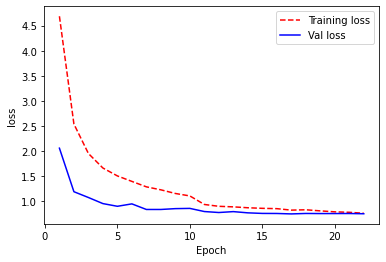

In [27]:
get_diagnostic_plot(model,'loss')

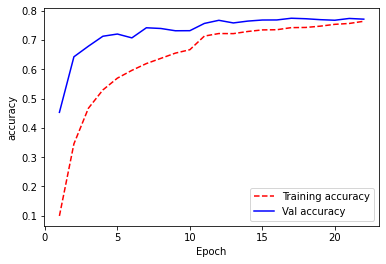

In [28]:
get_diagnostic_plot(model,'accuracy')

In [29]:
save_path = 'G:/Github/Dogs_breed_classification/resnet50_2/'
tf.keras.models.save_model(model,save_path)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: G:/Github/Dogs_breed_classification/resnet50_2/assets
